In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

from sklearn.utils import resample

import re

from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from string import punctuation

from tensorflow import keras
from keras import layers

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
data= pd.read_csv("/content/data (1).csv")
data

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
...,...,...
5837,RISING costs have forced packaging producer Hu...,negative
5838,Nordic Walking was first used as a summer trai...,neutral
5839,"According shipping company Viking Line , the E...",neutral
5840,"In the building and home improvement trade , s...",neutral


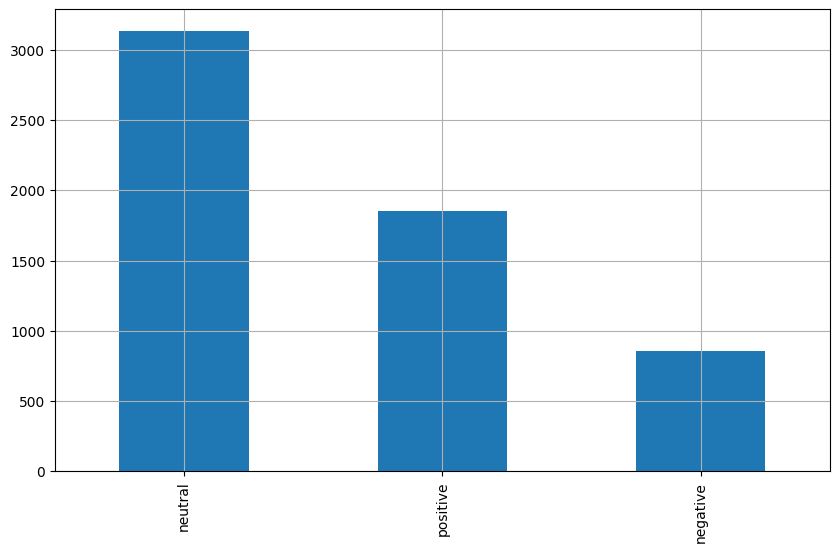

In [ ]:
data['Sentiment'].value_counts().plot(kind='bar',figsize=(10,6),grid='-')

plt.show()

In [ ]:
data['Sentiment'].value_counts()

neutral     3130
positive    1852
negative     860
Name: Sentiment, dtype: int64

In [ ]:
x= data['Sentence']
y= data['Sentiment']


In [ ]:
pattern = "[^a-zA-Z0-9$,.]"
x = [re.sub(pattern," ",sentence).lower().strip() for sentence in x]

In [ ]:
def prepare_data(df):
    data=df['Sentence']
    useless_words=list(stopwords.words('english'))+list(punctuation)

    lemmatizer=WordNetLemmatizer()
    corpus=data.tolist()
    final_corpus=[]

    for i in range(len(corpus)):
        word=word_tokenize(corpus[i].lower())
        word=[
            lemmatizer.lemmatize(y) for y in word if y not in useless_words
        ]
        j=" ".join(word)
        final_corpus.append(j)

    return final_corpus

In [ ]:
x={'sentence':x}
x=pd.DataFrame(x)
x.head()

,sentence
0,the geosolutions technology will leverage bene...
1,"$esi on lows, down $1.50 to $2.50 bk a real po..."
2,"for the last quarter of 2010 , componenta s n..."
3,according to the finnish russian chamber of co...
4,the swedish buyout firm has sold its remaining...


In [ ]:
final_corpus=prepare_data(data)

le=LabelEncoder()
data['Sentiment']=le.fit_transform(data['Sentiment'])

train_df={
    'sentence':final_corpus,
    'sentiment':data['Sentiment']
}

train_df=pd.DataFrame(train_df)
train_df.head()

,sentence,sentiment
0,geosolutions technology leverage benefon 's gp...,2
1,esi low 1.50 2.50 bk real possibility,0
2,last quarter 2010 componenta 's net sale doubl...,2
3,according finnish-russian chamber commerce maj...,1
4,swedish buyout firm sold remaining 22.4 percen...,1


In [ ]:
df_neutral = train_df[(train_df['sentiment']==1)]
df_negative = train_df[(train_df['sentiment']==0)]
df_positive = train_df[(train_df['sentiment']==2)]


# upsample minority classes
df_negative_upsampled = resample(df_negative,
                                 replace=True,
                                 n_samples= 3130,
                                 random_state=42)

df_positive_upsampled = resample(df_positive,
                                 replace=True,
                                 n_samples= 3130,
                                 random_state=42)


# Concatenate the upsampled dataframes with the neutral dataframe
df_final = pd.concat([df_negative_upsampled,df_neutral,df_positive_upsampled])

In [ ]:
df_final.shape


(9390, 2)

In [ ]:
df_final['sentiment'].value_counts()


0    3130
1    3130
2    3130
Name: sentiment, dtype: int64

In [ ]:
df_final.head()

,sentence,sentiment
742,currency effect 3.0 pct 20 mln euro 31.3 mln n...,0
3015,mflx pre mkt look like gap filled .... lookin ...,0
1898,however growth margin slowed due financial crisis,0
777,'s bad idea make 5 min prediction based faith ...,0
472,key price watch nflx previous double top rejec...,0


In [ ]:
MAX_NB_WORDS = 50000

MAX_SEQUENCE_LENGTH = 250

EMBEDDING_DIM = 100
tokenizer = keras.preprocessing.text.Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df_final['sentence'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 10053 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(df_final['sentence'].values)
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (9390, 250)


In [ ]:
Y = pd.get_dummies(df_final['sentiment']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (9390, 3)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)


(7512, 250) (7512, 3)
(1878, 250) (1878, 3)


In [ ]:
model = keras.Sequential()
model.add(keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(keras.layers.SpatialDropout1D(0.2))
model.add(keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(keras.layers.Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2)

Epoch 1/5
94/94 [==============================] - 45s 454ms/step - loss: 0.9988 - accuracy: 0.5295 - val_loss: 0.8219 - val_accuracy: 0.6873
Epoch 2/5
94/94 [==============================] - 41s 441ms/step - loss: 0.5460 - accuracy: 0.7993 - val_loss: 0.5672 - val_accuracy: 0.7858
Epoch 3/5
94/94 [==============================] - 42s 449ms/step - loss: 0.3085 - accuracy: 0.8887 - val_loss: 0.5602 - val_accuracy: 0.8190
Epoch 4/5
94/94 [==============================] - 46s 487ms/step - loss: 0.2311 - accuracy: 0.9155 - val_loss: 0.5587 - val_accuracy: 0.8290
Epoch 5/5
94/94 [==============================] - 42s 449ms/step - loss: 0.1931 - accuracy: 0.9246 - val_loss: 0.6173 - val_accuracy: 0.8257


In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

59/59 [==============================] - 4s 61ms/step - loss: 0.6014 - accuracy: 0.8237
Test set
  Loss: 0.601
  Accuracy: 0.824


In [ ]:
def get_plot(trained_model):
    accuracy=trained_model.history['accuracy']
    loss=trained_model.history['loss']
    val_accuracy=trained_model.history['val_accuracy']
    val_loss=trained_model.history['val_loss']
    epochs=[i for i in range(1,6)]

    plt.figure(figsize=(12,8))
    plt.plot(epochs,accuracy,'r',label='Training')
    plt.plot(epochs,val_accuracy,'--',label='Validation')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy',fontsize=15)
    plt.grid()
    plt.show()

    plt.figure(figsize=(12,8))
    plt.plot(epochs,loss,'r',label='Training')
    plt.plot(epochs,val_loss,'--',label='Validation')
    plt.legend()
    plt.title('Loss',fontsize=15)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid()
    plt.show()

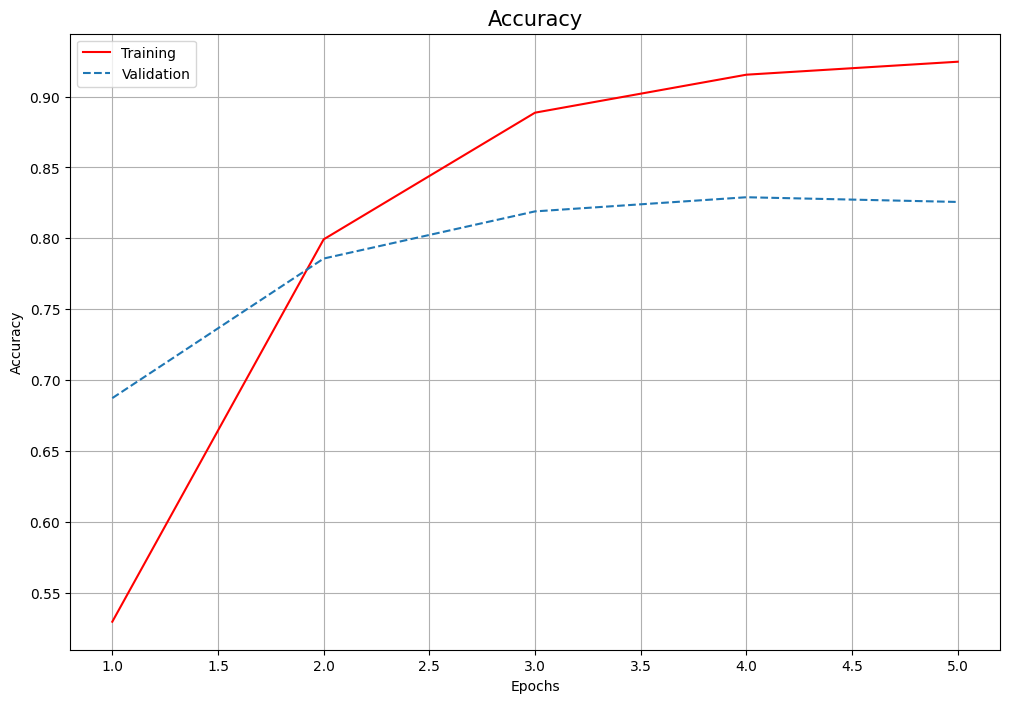

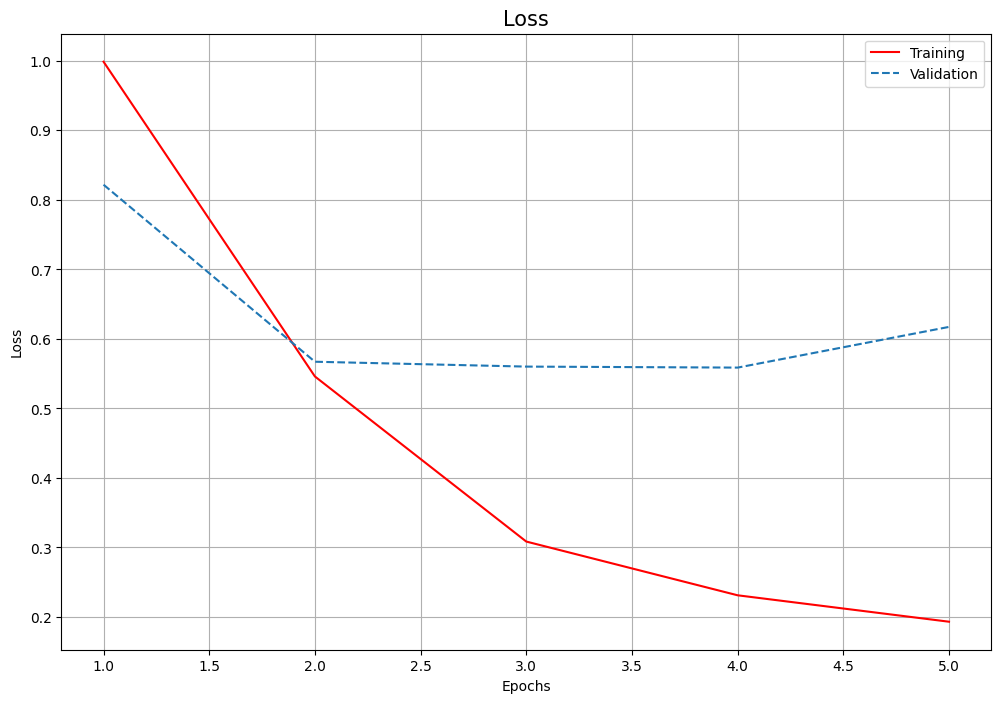

In [ ]:
get_plot(history)